# Warning: Unfinished Document. Work in Progress.

In [47]:
%pip install particle
%pip install sympy


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Lets start by defining a decay. In the code beow you can see how to define a simple utility, which given momenta will be able to calculate all needed rotations.

For simplicity we will choose a simple
As you see, the isobars are always isolated, meaning no isobar is the predecessor of another isobar. This makes the the full amplitude straightforward to calculate.

In [48]:
from decayangle.decay_topology import TopologyCollection, Node
from decayangle.config import config as cfg

# We can switch the backend to jax if we like, but this is usually not advisable
# Angles should be precomputed and thus jax is slower than numpy in most cases
# cfg.backend="jax"
# print(cfg.backend)

# Find the possible the decay topologies
tg = TopologyCollection(0, [1,2,3])
for decay_topology in tg.topologies:
    print(decay_topology)

Topology: ( 0 -> ( (2, 3) -> 2, 3 ), 1 )
Topology: ( 0 -> ( (1, 3) -> 1, 3 ), 2 )
Topology: ( 0 -> ( (1, 2) -> 1, 2 ), 3 )


First lets define some basic utility functions. This is not something you need to understand 100% on the first try.
What we do is set up the basic functional setup to be able to perform a three body analysis, which is the simplest case. 

In [49]:
from typing import NamedTuple, Callable
from math import prod
from particle import Particle
import numpy as np

def wigner_small_d(theta, j, m1, m2):
    """Calculate Wigner small-d function. Needs sympy.
      theta : angle
      j : spin (in units of 1/2, e.g. 1 for spin=1/2)
      m1 and m2 : spin projections (in units of 1/2)

    :param theta:
    :param j:
    :param m1: before rotation
    :param m2: after rotation

    """
    from sympy import Rational
    from sympy.abc import x
    from sympy.utilities.lambdify import lambdify
    from sympy.physics.quantum.spin import Rotation as Wigner
    j,m1,m2 = int(j),int(m1),int(m2)
    d = Wigner.d(Rational(j, 2), Rational(m2, 2), Rational(m1, 2), x).doit().evalf()
    d = lambdify(x, d, "numpy")(theta)
    # d = np.array(d)
    # d[np.isnan(d)] = 0
    d = np.nan_to_num(d, copy=True, nan=0.0)
    return d

    
def BWResonance(spin, mass, width):
    """Create a Breit-Wigner resonance function for a given spin.
    Args:
        spin (int): spin quantum number multiplied by 2
    """
    def f(s, L):
        return np.sqrt(s) / (s - mass**2 + 1j * mass * width)
    return f

class resonance:
    def __init__(self, spin, parity, mass, width, name, mother:Particle, bachelor:Particle, isobar: tuple):
        self.spin = spin
        self.mass = mass
        self.width = width
        self.lineshape = BWResonance(spin, mass, width)
        self.parity = parity
        self.name = name
        self.mother = mother
        self.bachelor = bachelor
        self.isobar = isobar


    @property
    def possible_helicities(self):
        return list(range(-self.spin, self.spin+1, 2))
    
    @property
    def isbar_spins(self):
        return [p.spin for p in self.isobar]
    
    @property
    def isobar_parities(self):
        return [p.parity for p in self.isobar]

    def LS_couplings_mother_decay(self):
        allowed_ls = []
        LSCoupling = NamedTuple('LSCoupling', [('L', int), ('S', int), ('coupling', complex)])
        for L in range(0, self.mother.spin + self.spin + self.bachelor.spin + 6, 2):
            for S in range(abs(L - self.mother.spin), L + self.mother.spin + 1, 2):
                if abs(L - S) <= self.mother.spin <= L + S:
                    allowed_ls.append((L, S))
        return {
            f"{self.name}:motherDecay:L{L}.S{S}": LSCoupling(L, S, 1 + 0j) for L, S in allowed_ls
        }
    
    def LS_coupling_resonance_decay(self):
        allowed_ls = []
        LSCoupling = NamedTuple('LSCoupling', [('L', int), ('S', int), ('coupling', complex)])
        for L in range(0, self.spin + sum(self.isbar_spins) + self.mother.spin, 2):
            for S in range(abs(L - self.spin), L + self.spin + 1, 2):
                if abs(L - S) <= self.spin <= L + S: # check J double
                    if prod(self.isobar_parities) * (-1)**(L) == self.parity: # check parity
                        allowed_ls.append((L, S))
        return {
            f"{self.name}:resonanceDecay:L{L}.S{S}": LSCoupling(L, S, 1 + 0j) for L, S in allowed_ls
        }
            
    def clebsch_gordan(self, j1, m1, j2, m2, J, M):
        """
        Return clebsch-Gordan coefficient. Note that all arguments should be multiplied by 2
        (e.g. 1 for spin 1/2, 2 for spin 1 etc.). Needs sympy.
        """
        from sympy.physics.quantum.cg import CG
        from sympy import Rational
        cg = CG(
                Rational(j1, 2),
                Rational(m1, 2),
                Rational(j2, 2),
                Rational(m2, 2),
                Rational(J, 2),
                Rational(M, 2),
            ).doit().evalf()
        cg = float(cg)
        if str(cg) == "nan":
            raise ValueError(f"CG({j1/2},{m1/2},{j2/2},{m2/2},{J/2},{M/2}) is not a number")
        return cg
    
    def helicity_coupling_times_lineshape(self, s, hi_, hj_):
        ls_resonance_decay = self.LS_coupling_resonance_decay()
        pi, pj = self.isobar
        h = sum(
            ls.coupling * self.lineshape(s, ls.L) * 
            self.clebsch_gordan(pi.spin, hi_, pj.spin, -hj_, ls.S,hi_ - hj_) * 
            self.clebsch_gordan(ls.S, hi_ - hj_, ls.L, 0 , self.spin, hi_ - hj_)
            for ls in ls_resonance_decay.values()
        )
        return h

    
    
    def h_mother(self,hk_, hiso_) -> float:
        # TODO: calculate the h values from the LS values and  clebsch gordans
        mother_decay = self.LS_couplings_mother_decay()
        pk = self.bachelor
        return sum(
            ls.coupling *  self.clebsch_gordan(self.spin, hiso_, pk.spin, -hk_, ls.S, hiso_ - hk_) * self.clebsch_gordan(ls.S, hiso_ - hk_, ls.L, 0 , self.mother.spin, hiso_ - hk_)
            for ls in mother_decay.values()
        )
       

        

possible_helicities = lambda spin: list(range(-spin, spin+1, 2))

The particle porperites can be fetched directly from the PDG, with the help of the particles project.

We go for a decay of $\Lambda_b \rightarrow \Lambda_c^+ D^0 K^-$

In [50]:
# shortcut to get the pdg parameters for our particles
class particle:
    def __init__(self, p):
        self.p = p 
    
    @property
    def spin(self):
        return int(self.p.J * 2)

    @property
    def parity(self):
        return self.p.P

    def __getattr__(self, attr):
        return getattr(self.p, attr)
    
    def helicities(self):
        return possible_helicities(self.spin)

p0 = particle(Particle.findall('Lambda(b)0')[0])
p1 = particle(Particle.findall('D0')[0])
p2 = particle(Particle.findall('Lambda(c)+')[0])
p3 = particle(Particle.findall('K-')[0])

particles = {
    0: p0,
    1: p1,
    2: p2,
    3: p3
}

for i in range(4):
    print(f"Particle {i}: {particles[i].name} spin: {particles[i].spin} helicities: {particles[i].helicities()}")


Particle 0: Lambda(b)0 spin: 1 helicities: [-1, 1]
Particle 1: D0 spin: 0 helicities: [0]
Particle 2: Lambda(c)+ spin: 1 helicities: [-1, 1]
Particle 3: K- spin: 0 helicities: [0]


Now we have the main components for the amplitude. We can describe the lineshape for as single resonance, we can compute helicity couplings and we can calculate all the angles. Only thing left to do is write the loops for the sums. The final form should look somewhat like this:

$\sum_{\mathrm{topologys}}\sum_{\{\lambda\}}\sum_{\{\lambda^{'}\}} R(m,\{\lambda^{'}\}) d(\theta, \lambda_k^{'}, \lambda_{ij}^{'}) d(\phi_1,\lambda^{'}_1,\lambda_1)d(\phi_2,\lambda^{'}_2,\lambda_2)d(\phi_3,\lambda^{'}_3,\lambda_3)$

This simply describes the sum over all different possible decay topologys, and the sum over all possible helicities.
A second sum over the primes helicities $\{\lambda^{'}\}$ in conjunction with the wigner rotation $d(\theta, \lambda_k^{'}, \lambda_{ij}^{'})$ describes the needed basis change after the rotation to move the $(ij)$ isobar onto the z axis.

The rotations $d(\phi_1,\lambda^{'}_1,\lambda_1)d(\phi_2,\lambda^{'}_2,\lambda_2)d(\phi_3,\lambda^{'}_3,\lambda_3)$ describe the rotations rotating the final states of the different chains to a common constellation.

The $R(m,\{\lambda^{'}\})$ is the lineshape of the resonance together with the couplings $H_{0 \rightarrow (ij)\, k}^{\lambda_0, \lambda_{(ij) - \lambda_k}} \cdot X(m,L) \cdot H_{(ij) \rightarrow i\, j}^{\lambda_{(ij)}, \lambda_i^{'} - \lambda_j^{'}}$. 
The couplings $H$ are called helicity couplings 

In [51]:
import phasespace as phsp

def generate_momenta(n=1_000):
    weights, p = phsp.nbody_decay(particles[0].mass, [
    particles[1].mass,
    particles[2].mass,
    particles[3].mass
    ]).generate(n)


    momenta = {
        i + 1: np.array(p[f"p_{i}"])
            for i, _ in enumerate( [1,2,3])
    }
    return momenta, weights

momenta, weights = generate_momenta(100_000)


Next we want to define the structure of the amplitude

In [52]:
reference_topology = tg.topologies[0]
momenta = reference_topology.to_rest_frame(momenta)

# We can define resonances based on the isobar they can appear in 
resonance_lineshapes = {
    (1, 3): [ 
                resonance(0, 1, 2800, 30, 'D2800', p0, p2, (p1, p3)),
                resonance(1, 1, 2800, 80, 'D2800', p0, p2, (p1, p3)) 
            ], 
    (2 ,3): [
                resonance(1, -1, 2900, 20, 'Xi_c', p0, p1, (p2, p3)),
                resonance(3, -1, 3200, 20, 'Xi_c2', p0, p1, (p2, p3)),
                resonance(5, -1, 3600, 20, 'Xi_c2', p0, p1, (p2, p3)),
                resonance(5, -1, 3500, 20, 'Xi_c2', p0, p1, (p2, p3)),
                resonance(5, -1, 3100, 20, 'Xi_c2', p0, p1, (p2, p3)),

            ]   
    }

Now we need to get the values for our rotations. For this we can simply iterate through all the possible decay topologys, the ```TopologyCollection``` Object generates for us.

In [53]:
for topology in tg.topologies:
        final_state_rotations = reference_topology.relative_wigner_angles(topology, momenta)
        isobars = topology.helicity_angles(momenta)

topo = tg.topologies[0]
h = topo.helicity_angles(momenta)

For each topology, we see, that we get exactly one isobar constellation. We also see, that of the two angles we compute, only one is non 0 (or $\pi$).

This is expected, as we are already in the decay plane. Thus this angle should go to 0. Computing it could be left out.

In [54]:
from functools import partial

# particle 1 
spin1 = p1.spin
helicities1 = possible_helicities(spin1)

# particle 2
spin2 = p2.spin
helicities2 = possible_helicities(spin2)

# particle 3
spin3 = p3.spin
helicities3 = possible_helicities(spin3)

spin0 = p0.spin
helicities0 = possible_helicities(spin0)

# precompute the angles
final_state_rotations = {
    topology.tuple: reference_topology.relative_wigner_angles(topology, momenta)
    for topology in tg.topologies
}
helicity_angles = {
    topology.tuple: topology.helicity_angles(momenta)
    for topology in tg.topologies
}

def f(h0, h1, h2, h3):
    helicity_list = [h0, h1, h2, h3]
    spin_list = [spin0, spin1, spin2, spin3]
    amplitude = 0
    for topology in tg.topologies:
        final_state_rotation = final_state_rotations[topology.tuple]
        isobars = helicity_angles[topology.tuple]
        for (isobar, bachelor), (phi, theta) in isobars.items():
            if isobar not in resonance_lineshapes:
                # guard clause against key errors
                continue
            # determinethe correct helicities
            (i,j), k = isobar, bachelor
            hi ,hj, hk = helicity_list[i], helicity_list[j], helicity_list[k]
            si, sj, sk = spin_list[i], spin_list[j], spin_list[k]
            
            theta_ij = isobars[isobar].theta_rf

            amplitude += sum(
                resonance.helicity_coupling_times_lineshape(topology.nodes[isobar].mass(momenta)**2,hi_, hj_) * 
                wigner_small_d(theta, spin0, h0,  h_iso - hk_) * # mother decay
                wigner_small_d(theta_ij, resonance.spin, h_iso,hi_-hj)* # isobar decay
                wigner_small_d(final_state_rotation[i].theta_rf, si, hi, hi_) * wigner_small_d(final_state_rotation[j].theta_rf, sj, hj, hj_) * 
                wigner_small_d(final_state_rotation[k].theta_rf, sk, hk, hk_) * 
                resonance.h_mother(hk_, h_iso)
                for resonance in resonance_lineshapes.get(isobar, [])
                for h_iso in resonance.possible_helicities
                for hk_ in particles[bachelor].helicities()
                for hi_ in particles[isobar[0]].helicities()
                for hj_ in particles[isobar[1]].helicities()
            )
    return amplitude

f(helicities0[0], helicities1[0], helicities2[0], helicities3[0])

(100000, 4)


array([-0.01120505+1.12328402e-02j, -0.00032946+2.43642296e-05j,
       -0.01224354-4.81475675e-03j, ...,  0.00159138+8.97182790e-04j,
        0.00494926+2.94596982e-04j,  0.021485  -1.15664960e-02j])

In [55]:

full_amplitude = sum(
    abs(f(l1, l2, l3, l4))**2
    for l1 in helicities0
    for l2 in helicities1
    for l3 in helicities2
    for l4 in helicities3
)
import matplotlib.pyplot as plt
from decayangle.kinematics import mass_squared

m2_12 = mass_squared(momenta[1] + momenta[2])**0.5
m2_13 = mass_squared(momenta[1] + momenta[3])**0.5
m2_23 = mass_squared(momenta[2] + momenta[3])**0.5
full_amplitude

(100000, 4)
(100000, 4)
(100000, 4)
(100000, 4)


array([2.21541641e-03, 1.53995001e-05, 5.36909029e-04, ...,
       2.59322404e-04, 1.57103547e-04, 7.02180360e-04])

Text(0.5, 0, '$M(\\Lambda_c \\,D^0)$')

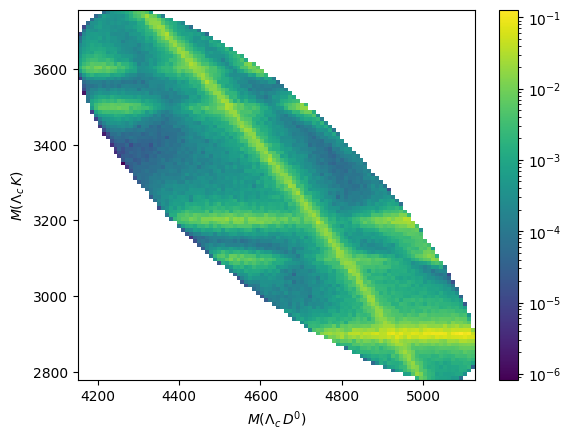

In [56]:
from matplotlib.colors import LogNorm
a= plt.hist2d(m2_12, m2_23, bins=100, weights=full_amplitude*weights, norm=LogNorm())
plt.colorbar()
plt.ylabel(r"$M(\Lambda_c\, K)$")
plt.xlabel(r"$M(\Lambda_c \,D^0)$")

Text(0.5, 0, '$M(D^0 \\, K)$')

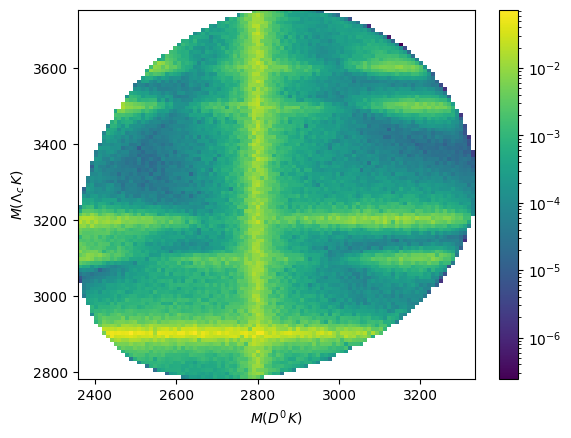

In [57]:
a= plt.hist2d(m2_13, m2_23, bins=100, weights=full_amplitude*weights, norm=LogNorm())
plt.colorbar()
plt.ylabel(r"$M(\Lambda_c\, K)$")
plt.xlabel(r"$M(D^0 \, K)$")